# this is check the model using no fucntion at all.
use constant solid diffusion

In [1]:
import pybamm;import pandas as pd   ;import numpy as np;import os;import matplotlib.pyplot as plt;import os;#import imageio
from scipy.io import savemat,loadmat;from pybamm import constants,exp,sqrt;
import matplotlib as mpl; 
fs=17; # or we can set import matplotlib.pyplot as plt then say 'mpl.rc...'
import openpyxl
import traceback
import multiprocessing
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)

In [2]:
import sys  
str_path_0 = os.path.abspath(os.path.join(pybamm.__path__[0],'..'))
str_path_1 = os.path.abspath(os.path.join(str_path_0,"wip\Rio_Code\Fun_P3"))
sys.path.append(str_path_1) 
from Fun_P3 import *
BasicPath = 'D:/OneDrive - Imperial College London/SimDataSave/P3R13/'; 
Target  = 'Test_NoFunc_Ds_Constant/' 
if not os.path.exists(BasicPath + Target):
   os.mkdir(BasicPath + Target)

In [3]:
# Define 3 models: normal DFN, single transport by high Dec, double transport
Model_DFN  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "single no consume wo refill",
    "electrolyte conductivity": "full"  ,}) 
Model_SD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "full"  ,}) 
Model_DD  = pybamm.lithium_ion.DFN(options={
    "solvent diffusion": "double spatial consume w refill",
    "electrolyte conductivity": "sol full"  ,}) 
Model_All =[ Model_DFN,  Model_SD, Model_DD ]
Str_model =[ 'Model_DFN',  'Model_SD', 'Model_DD' ]

para=pybamm.ParameterValues("Li2023_ECdrag")
para.update({"EC Lithium ion cross diffusivity [m2.s-1]":Cross_diffusivity_1p5E_12})
para.update({"Cation transference number":electrolyte_transference_number_EC_EMC_3_7_Landesfeind2019_Con})
para.update({"Electrolyte conductivity [S.m-1]":electrolyte_conductivity_EC_EMC_3_7_Landesfeind2019_Con})
para.update({"Electrolyte diffusivity [m2.s-1]":electrolyte_diffusivity_EC_EMC_3_7_Landesfeind2019_Con})

para.update({"EC initial concentration in electrolyte [mol.m-3]":3500})
para.update({"Measured dLJP_dce":dLJP_dce_Nyman_2011})
para.update({"Measured dLJP_dcEC":dLJP_dcEC_Nyman_2011})

In [4]:
V_max = 4.2;        V_min = 2.5;
exp  = pybamm.Experiment(
    [ (
        #f"Hold at {V_max} V until C/5",
        f"Discharge at 1 C until {V_min} V", 
        f"Charge at 1 C until {V_max} V", 
        f"Rest for 3 h",)    ] * 1 )  

In [5]:
pybamm.log(2.7)

Scalar(-0x3a36c298812a809a, 0.9932517730102834, children=[], domains={})

In [6]:
Sol_all =[];
for model in Model_All:
    c_e = model.variables["Electrolyte concentration [mol.m-3]"]
    c_EC= model.variables["EC concentration [mol.m-3]"]
    T = model.variables["Cell temperature [K]"]
    D_e = para["Electrolyte diffusivity [m2.s-1]"]
    D_EC= para["EC diffusivity in electrolyte [m2.s-1]"]
    sigma_e = para["Electrolyte conductivity [S.m-1]"]
    Xi = para["EC transference number"]
    model.variables["Electrolyte diffusivity [m2.s-1]"] = D_e(c_e,c_EC, T)
    model.variables["EC diffusivity in electrolyte [m2.s-1]"] = D_EC(c_e,c_EC, T)
    model.variables["Electrolyte conductivity [S.m-1]"] = sigma_e(c_e,c_EC, T)
    model.variables["EC transference number"] = Xi(c_e,c_EC, T)
    model.variables["c(EC) over c(Li+)"] = c_EC / c_e
    t_0plus = para["Cation transference number"]
    model.variables["Cation transference number"] = t_0plus(c_e,c_EC, T)
    
    sim    = pybamm.Simulation(
        model, experiment = exp,
        parameter_values = para,
        solver = pybamm.CasadiSolver(),)       
    Sol_all.append(sim.solve())

In [7]:
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
var_elely = [
    "Electrolyte potential [V]",
    "EC concentration [mol.m-3]",
    "Electrolyte concentration [mol.m-3]",
    "EC transference number",
    "Electrolyte conductivity [S.m-1]",
    "Electrolyte diffusivity [m2.s-1]",
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol_all], var_elely,Str_model,variable_limits='fixed',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=4.652638945206353, step=0.04652638945206353)…

In [8]:
# rough estimation of concentration overpotential
def eta_l(c_l):
    return -5.394e-6 - 3.616e-2/c_l
def eta_e(c_e):
    return -5.326e-5 - 2.47e-2/c_e
c_l_left = 4000;   c_l_right =8000;
c_e_left = 500;   c_e_right =1500;
eta_l_delta = (eta_l(c_l_right)+eta_l(c_l_left)) * (c_l_right-c_l_left) / 2
eta_e_delta = (eta_e(c_e_right)+eta_e(c_e_left)) * (c_e_right-c_e_left) / 2
print(f"* Solvent concentration overpotential is {format(eta_l_delta*1000,'.1f')} mV")
print(f"Li+ concentration overpotential is {format(eta_e_delta*1000,'.1f')} mV")
print(6500*0.8,6500*1.2)

* Solvent concentration overpotential is -48.7 mV
Li+ concentration overpotential is -86.2 mV
5200.0 7800.0


In [9]:
font = {'family' : 'DejaVu Sans','size'   : 17}
mpl.rc('font', **font)
output_variables3 = [
    "Electrolyte potential [V]",
    "Positive electrode potential [V]",
    "Negative electrode potential [V]",
    "Positive current collector potential [V]", 
    "Terminal voltage [V]", 
]
quick_plot = pybamm.QuickPlot(
    [sol for sol in Sol_all], output_variables3,Str_model,variable_limits='fixed',
    time_unit='hours',
    spatial_unit='mm',     #  (“m”, “mm”, or “um”)
    n_rows=2) #figsize = (18,12),
quick_plot.dynamic_plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=4.652638945206353, step=0.04652638945206353)…

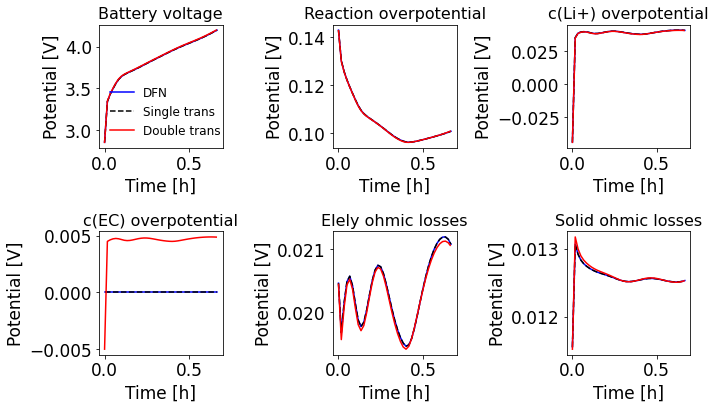

In [10]:
Colors = ['b','k','r',];LS = ['-','--','-'];MS=['o','^','h'];Str=[ 'DFN',  'Single trans', 'Double trans' ]
fig, axs = plt.subplots(2,3, figsize=(10,6),tight_layout=True)
Keys_t_var = [
    "Battery voltage [V]",
    "X-averaged battery reaction overpotential [V]",
    "X-averaged battery concentration overpotential [V]",
    "X-averaged EC concentration overpotential [V]", # Mark Ruihe add
    "X-averaged battery electrolyte ohmic losses [V]",
    "X-averaged battery solid phase ohmic losses [V]",
]
Title_keys = [
    "Battery voltage",
    "Reaction overpotential",
    "c(Li+) overpotential",
    "c(EC) overpotential",
    "Elely ohmic losses",
    "Solid ohmic losses"
]
for k in range(0,3):
    step_no = 1
    time_1 = (
        Sol_all[k].cycles[0].steps[step_no]['Time [h]'].entries
        -Sol_all[k].cycles[0].steps[step_no]['Time [h]'].entries[0] )
    for i in range(0,6): # 0 1 2 3 4 5 --> [0,0] [0,1], [0,2], [1,0], [1,1], [1,2]   
        var =  Sol_all[k].cycles[0].steps[step_no][Keys_t_var[i]].entries
        if i < 3:
            m=0; n =i
        else:
            m=1; n=i-3
        axs[m,n].plot(time_1, var,color=Colors[k],linestyle=LS[k],label=Str[k]) # label="1st cycle"
        axs[m,n].set_title(Title_keys[i],fontdict={'family':'DejaVu Sans','size':fs-1})
        axs[m,n].set_ylabel("Potential [V]",   fontdict={'family':'DejaVu Sans','size':fs})
        axs[m,n].set_xlabel('Time [h]',   fontdict={'family':'DejaVu Sans','size':fs})
        #axs[m,n].set_ylim(-1.2,0.5)
        
        labels = axs[m,n].get_xticklabels() + axs[m,n].get_yticklabels(); 
        [label.set_fontname('DejaVu Sans') for label in labels]
        axs[0,0].legend(prop={'family':'DejaVu Sans','size':fs-5},loc='best',frameon=False)  
    #axs[0,0].set_ylim(2.49,4.2)